In [ ]:
# default_exp templates

# Templates

> Templates are used to define chemical spaces using easily calculable properties

Tempates are a core concept in MRL used to define chemical spaces. Tempates collect a series of molecular heuristics and validate if a molecule meets those criteria. For example:

```
Molecular weight: 250-450
Rotatable bonds: Less than 8
PAINS Filter: Pass
```

Templates can also be used to assign a score for meeting heuristic criteria. This allows us to define different criteria for __must-have__ molecular properties versus __nice-to-have___ chemical properties. In a reinforcement learning context, this translates into giving a score bonus to molecules that fit the nice-to-have criteria. Scores can also be negative to allow for penalizing a molecule that still passes the must-have criteria.

```
Must Have:
Molecular weight: 250-450, 
Rotatable bonds: Less than 8
PAINS Filter: Pass

Nice To Have:
Molecular weight: 350-400 (+1), 
TPSA: Less than 80 (+1)
Substructure Match: '[#6]1:[#6]:[#7]:[#6]:[#6]:[#6]:1' (+3)
Substructure Match: '[#6]1:[#6]:[#7]:[#7]:[#7]:[#6]:1' (-1)
```

Based on the above criteria, a molecule that passes the must-have criteria could get a score between -1 and +5 based on meeting the nice-to-have criteria.

In [ ]:
#hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

In [ ]:
# export
# hide
from mrl.imports import *
from mrl.core import *
from mrl.chem import *

//anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Property Functions

`PropertyFunction` classes serve two basic purposes. The `calc_property` function computes some function of a `Mol` object. The `criteria` function takes the output of `calc_property` and converts it to a boolean value. 

Property functions and classes that use property functions follow the convention that `True` means the input `Mol` has passed the `criteria` function, while `False` means the `Mol` has failed the `criteria`.

This is important to keep in mind for substructure matching. Substructure matching with `Catalog` classes follows return `True` when a substructure match is found. If this is the desired behavior (ie validating a desired struture is the `Mol`), use the `SmartsMatch` class as a property function. If the opposite behavior is desired (ie excluding structures that match a filter), use the `ExclusionMatch` property function which returns `False` when matches are found and `True` when no matches are found

In [ ]:
# export

class PropertyFunction():
    '''
    PropertyFunction - base class for property functions. 
    
    When subclassing, define the `calc_property` and `criteria` functions
    '''
    def __call__(self, mol):
        prop = self.calc_property(mol)
        prop_bool = self.criteria(prop)
        return prop_bool
        
    def calc_property(self, mol):
        pass
    
    def criteria(self, prop):
        pass
    
    
class MolProperty(PropertyFunction):
    '''
    MolProperty - base property class for all properties that can be computed as `mol_function(mol)`
        
    ex: prop_func = MolProperty(molwt)
    
    note that the `criteria` function is not defined here
    '''
    def __init__(self, mol_function):
        self.mol_function = mol_function
        
    def calc_property(self, mol):
        mol = to_mol(mol)
        return self.mol_function(mol)
    
    
class RangeProperty(MolProperty):
    '''
    RangeProperty - class for calculating properties and evaluating them within a defined range
    
    Inputs:
        `mol_function` - any function that takes as input a `Mol` and returns a numeric value
        `min_val` - float, None, minimum value. Ignored if None
        `max_val` - float, None, maximum value. Ignored if None
        
    One of `min_val`, `max_val` must not be None
    
    prop_func = RangeProperty(molwt, 100, 300)
    prop_func(to_mol('O=C(C)Oc1ccccc1C(=O)O'))
    >> True
    '''
    def __init__(self, mol_function, min_val=None, max_val=None):
        super().__init__(mol_function)
        self.min_val = min_val
        self.max_val = max_val
        assert (self.min_val is not None) or (self.max_val is not None), "One bound must be specified"
        
    def criteria(self, prop):
        lower_bound = (prop>=self.min_val) if self.min_val is not None else True
        upper_bound = (prop<=self.max_val) if self.max_val is not None else True
        output = lower_bound and upper_bound
        
        return output


In [ ]:
#export

class SmartsMatch(PropertyFunction):
    '''
    SmartsMatch - class for substructure matching a `Mol` against a `Catalog`
    
    Inputs:
        `catalog` - a subclass of `Catalog`
        `crit` - str ('any', 'all'). If any, will return True if any structure in `catalog` matches the `Mol`.
        
    catalog = PAINSACatalog()
    prop_func = SmartsMatch(catalog, crit='any')
    prop_func(to_mol('O=C(Cn1cnc2c1c(=O)n(C)c(=O)n2C)N/N=C/c1c(O)ccc2c1cccc2'))
    >> True
    
    prop_func = SmartsMatch(catalog, crit='all')
    prop_func(to_mol('O=C(Cn1cnc2c1c(=O)n(C)c(=O)n2C)N/N=C/c1c(O)ccc2c1cccc2'))
    >> False
    '''
    def __init__(self, catalog, crit='any'):
        self.catalog = catalog
        assert isinstance(self.catalog, Catalog), "`catalog_match` must be a subclass of `Catalog`"
        assert crit in ('any', 'all'), "`crit` must be one of ('any', 'all')"
        self.crit = crit
        
    def calc_property(self, mol):
        return self.catalog(mol, criteria=self.crit)
    
    def criteria(self, prop):
        if not type(prop) == list:
            prop = [prop]
            
        if self.crit=='any':
            output = any(prop)
        else:
            output = all(prop)
        
        return output
    
    @classmethod
    def from_smarts(cls, smarts, crit='any'):
        "Returns a `SmartsMatch` object with a `SmartsCatalog` from the given `smarts`"
        catalog = SmartsCatalog(smarts)
        return cls(catalog, crit)
    

In [ ]:
show_doc(SmartsMatch.from_smarts)

<h4 id="SmartsMatch.from_smarts" class="doc_header"><code>SmartsMatch.from_smarts</code><a href="__main__.py#L40" class="source_link" style="float:right">[source]</a></h4>

> <code>SmartsMatch.from_smarts</code>(**`smarts`**, **`crit`**=*`'any'`*)

Returns a `SmartsMatch` object with a [`SmartsCatalog`](/mrl/chem.html#SmartsCatalog) from the given `smarts`

In [ ]:
#export

class ExclusionMatch(SmartsMatch):
    '''
    ExclusionMatch - class for exclusion matching a `Mol` against a `Catalog`. 
    Returns `False` when `Mol` matches one of the filters in `Catalog`
    
    Inputs:
        `catalog` - a subclass of `Catalog`
        `crit` - str ('any', 'all'). If any, will return True if any structure in `catalog` matches the `Mol`.
    '''
    def criteria(sef, prop):
        return not super().criteria(prop)

In [ ]:
prop_func = RangeProperty(molwt, 100, 300)
assert prop_func(to_mol('O=C(C)Oc1ccccc1C(=O)O')) == True

prop_func = RangeProperty(molwt, 400, 500)
assert prop_func(to_mol('O=C(C)Oc1ccccc1C(=O)O')) == False

smarts = [
    '[*]-[#6]1:[#6]:[#6](-[#0]):[#6]:[#6](-[*]):[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[*]):[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1',
    '[*]-[#6]1:[#6]:[#6](-[#7]-[*]):[#6]:[#6]:[#6]:1',
    '[#6]1:[#6]:[#7]:[#6]:[#6]:[#6]:1'
]

smiles = [
    'c1ccccc1',
    'Cc1cc(NC)ccc1',
    'Cc1cc(NC)cnc1',
    'Cc1cccc(NCc2ccccc2)c1'
]

mols = [to_mol(i) for i in smiles]

prop_func = SmartsMatch.from_smarts(smarts, crit='any')
assert prop_func(mols[1]) == True

catalog = SmartsCatalog(smarts)
prop_func = SmartsMatch(catalog, crit='all')
assert prop_func(mols[1]) == False

prop_func = ExclusionMatch.from_smarts(smarts, crit='any')
assert prop_func(mols[1]) == False

## Score Functions

`ScoreFunction` classes take the results of a `PropertyFunction` (both `calc_property` and `criteria`) and return a numeric score.

`ConstantScore` returns a standard value based on if the `criteria_output` is `True` or `False`. For more sophisticated scores like those seen in MPO functions, something like `LinearDecayScore` can be used, which returns a constant score within a certain range, but decays the score outside that range.

`ScoreFunction` can be subclassed with any variant that takes as input `property_output` and `criteria_output` and returns a numeric value

In [ ]:
# export

class ScoreFunction():
    "Base score function"
    def __call__(self, property_output, criteria_output):
        pass
    
class NoScore(ScoreFunction):
    "Pass through for no score"
    def __call__(self, property_output, criteria_output):
        return 0.
    
class ConstantScore(ScoreFunction):
    '''
    ConstantScore - returns `pass_score` if `criteria_output=True`, else `fail_score
    '''
    def __init__(self, pass_score, fail_score=0.):
        self.pass_score = pass_score
        self.fail_score = fail_score
        
    def __call__(self, property_output, criteria_output):
        if criteria_output:
            output = self.pass_score
        else:
            output = self.fail_score
            
        return output
    
class LinearDecayScore(ConstantScore):
    '''
    LinearDecayScore - score with linear decay. `low_start<low_end<high_start<high_end`
    
    Returns `pass_score` if `criteria_output=True` and 
    `low_end<=property_output<=high_start`. If `low_start<=property_output<=low_end` or 
    `high_start<=property_output<=high_end`, the score is a linear interpolation between `pass_score` 
    and `fail_score`. Otherwise, returns `fail_score`.
    
    One of `low_end`, `high_start` must be not None.
    
    If one of `low_end`, `high_start` is None, the corresponding bound is ignored
    
    if `low_start` or `high_end` is None, the score immediately drops to `fail_score`
    
    '''
    # low_start < low_end < high_start < high_end
    def __init__(self, pass_score, low_start, low_end, 
                 high_start, high_end, fail_score=0.):
        super().__init__(pass_score, fail_score)
        
        self.low_start = low_start
        self.high_start = high_start
        
        self.low_end = low_end
        self.high_end = high_end
        
        assert (self.low_end is not None) or (self.high_start is not None), "One of (low_end, high_start) must not be None"
        
    def check_bound(self, property_output, bound, boundtype):
        if bound is None:
            output = True
        else:
            if boundtype=='low':
                output = property_output>=bound
            else:
                output = property_output<=bound
        
        return output
        
    def __call__(self, property_output, criteria_output):
        
        if criteria_output:
            
            low_bound = self.check_bound(property_output, self.low_end, 'low')
            high_bound = self.check_bound(property_output, self.high_start, 'high')
            
            if low_bound and high_bound:
                # in main range
                output = self.pass_score
                
            elif low_bound:
                # above high start:
                high_end = self.check_bound(property_output, self.high_end, 'high')
                
                if high_end:
                    # between high_start and high_end
                    if (self.high_start is not None) and (self.high_end is not None):
                        fraction = (property_output - self.high_start)/(self.high_end - self.high_start)
                        output = self.pass_score*(1-fraction) + self.fail_score*fraction
                    else:
                        output = self.fail_score
                    
                else:
                    output = self.fail_score
                    
            else:
                # below low end
                low_start = self.check_bound(property_output, self.low_start, 'low')
                
                if low_start:
                    # between low_start and low_end
                    if (self.low_start is not None) and (self.low_end is not None):
                        fraction = (property_output - self.low_start)/(self.low_end - self.low_start)
                        output = self.pass_score*fraction + self.fail_score*(1-fraction)
                    else:
                        output = self.fail_score
                        
                else:
                    output = self.fail_score

        else:
            output = self.fail_score
            
        return output


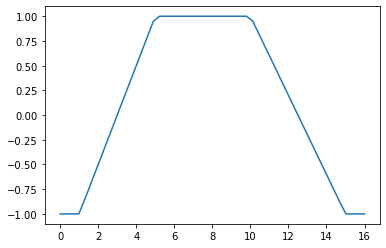

In [ ]:
score = LinearDecayScore(1, 1,5,10,15, fail_score=-1)
plt.plot(np.linspace(0,16),[score(i, True) for i in np.linspace(0,16)])

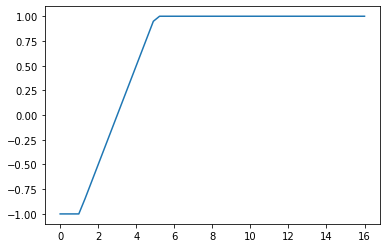

In [ ]:
score = LinearDecayScore(1, 1,5,None, None, fail_score=-1)
plt.plot(np.linspace(0,16),[score(i, True) for i in np.linspace(0,16)])

## Filter Functions

Filter functions bundle a `PropertyFunction` with a `ScoreFunction`

In [ ]:
# export

class FilterFunction():
    def __init__(self, property_function, score_function, name=None, fail_score=0.):
        self.property_function = property_function
        assert isinstance(self.property_function, PropertyFunction), ("`property_function` must "
                                                                      "subclass PropertyFunction")
        self.score_function = self.set_score(score_function, fail_score)
        self.name = name
        
    def set_score(self, score_function, fail_score):
        if score_function is None:
            score = NoScore()
        elif type(score_function) in (int, float):
            score = ConstantScore(score_function, fail_score=fail_score)
        elif isinstance(score, ScoreFunction):
            score = score
        else:
            raise ValueError('Invalid score_function input, must be one of (None, int, float, ScoreFunction)')
            
        return score
    
    def __call__(self, mol, with_score=True):
        output = maybe_parallel(self.eval_mol, mol, with_score=with_score)
        return output
        
    def eval_mol(self, mol, with_score=True):
        mol = to_mol(mol)
        property_output = self.property_function.calc_property(mol)
        criteria_output = self.property_function.criteria(property_output)
        
        if with_score:
            output = self.score_function(property_output, criteria_output)
        else:
            output = criteria_output
            
        return output
    
    def __repr__(self):
        if self.name is not None:
            output = f'{self.name}'
        else:
            output = 'Filter'
            
        return output
    
    
class PropertyFilter(FilterFunction):
    def __init__(self, mol_function, min_val, max_val, score, fail_score=0., name=None):
        property_function = RangeProperty(mol_function, min_val, max_val)
                
        if name is None:
            name = mol_function.__name__ + f' ({min_val}, {max_val})'
        
        super().__init__(property_function, score, name, fail_score=fail_score)
        

class StrucureFilter(FilterFunction):
    def __init__(self, smarts, score, exclude=True, criteria='any', name=None, fail_score=0.):
        catalog = self.get_catalog(smarts)
        if exclude:
            property_function = ExclusionMatch(catalog, crit=criteria)
        else:
            property_function = SmartsMatch(catalog, crit=criteria)
            
        if name is None:
            name = f'Structure filter, criteria: {criteria}, exclude: {exclude}'
            
        super().__init__(property_function, score, name, fail_score=fail_score)
    
    def get_catalog(self, smarts):
        if isinstance(smarts, Catalog):
            smarts = smarts
        else:
            smarts = SmartsCatalog(smarts)
        return smarts

In [ ]:
f1 = StrucureFilter(smarts, 1, exclude=True, criteria='any')
f2 = PropertyFilter(heteroatoms, 1, 5, 1)

In [ ]:
f1(mols)

[1, 0.0, 0.0, 0.0]

In [ ]:
f2(mols)

[0.0, 1, 1, 1]